In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore');
import os
import sys

In [139]:
# Alternate Dataset for test purposes.# os.chdir("C:/Users/Hilak/Desktop/INTERESTS/Machine Learning A-Z Template Folder/Part 3 - Classification/Section 14 - Logistic Regression");
training_set = pd.read_csv("Social_Network_Ads.csv");
X = training_set.iloc[:, 1:4].values
y = training_set.iloc[:, 4].values
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le_x = LabelEncoder()
X[:,0] = le_x.fit_transform(X[:,0])
ohe = OneHotEncoder(categorical_features = [0])
X = ohe.fit_transform(X).toarray()
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X[:,2:4] = ss.fit_transform(X[:, 2:4])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train = X_train.T
X_test = X_test.T

In [105]:
# os.chdir("C:\\Users\\Hilak\\Desktop\\INTERESTS\\Machine Learning A-Z Template Folder\\Part 8 - Deep Learning\\Section 39 - Artificial Neural Networks (ANN)");
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_test, X_CV, y_test, y_CV = train_test_split(X, y, test_size = 0.5)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train.T
X_test = X_test.T
X_CV = X_CV.T

In [207]:
def sigmoid(z) : 
    return 1./(1 + np.exp(-z))
def sigmoid_prime(z) :
    return sigmoid(z)*(1-sigmoid(z))
def ReLU(z) : 
    return (z*(z > 0))
def ReLU_prime(z) :
    return 1*(z>=0)
def lReLU(z) : 
    return np.maximum(z/100,z)
def lReLU_prime(z) :
    z = 1*(z>=0)
    z[z==0] = 1/100
    return z
def tanh(z) : 
    return np.tanh(z)
def tanh_prime(z) : 
    return (1-tanh(z)**2)

class NeuralNet : 
    def __init__(self, layers, X, y, ac_func='sigmoid', init_method='gaussian', loss_func='b_ce', W=np.array([]), B=np.array([])) : 
        self.layers = layers
        self.W = None
        self.B = None
        self.m = X.shape[1]
        self.n = [X.shape[0], *layers]
        self.X = X
        self.y = y
        self.cost = []
        self.acc = 0
        self.ac_func = ac_func
        self.loss = loss_func
        if len(W) and len(B) :
            self.W = W
            self.B = B
        else : 
            if init_method=='gaussian': 
                self.W = [np.random.randn(self.n[nl], self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.random.randn(nl,1) for nl in self.layers]
            elif init_method == 'random':
                self.W = [np.random.rand(self.n[nl], self.n[nl-1]) for nl in range(1,len(self.n))]
                self.B = [np.random.rand(nl,1) for nl in self.layers]
            elif init_method == 'zeros':
                self.W = [np.zeros((self.n[nl], self.n[nl-1]), 'float32') for nl in range(1,len(self.n))]
                self.B = [np.zeros((nl,1), 'float32') for nl in self.layers]
    
    def startTraining(self, epochs, alpha, interval=100):
        start = time.time()
        for i in range(epochs+1) : 
            z,a = self._feedForward()
            delta = self._cost_derivative(a[-1])
            for l in range(1,len(z)) : 
                delta_w = np.dot(delta, a[-l-1].T)
                delta_b = np.dot(delta, np.ones((self.m,1), 'int32'))
                self.W[-l] = self.W[-l] - (alpha/self.m)*delta_w
                self.B[-l] = self.B[-l] - (alpha/self.m)*delta_b
                if self.ac_func == 'sigmoid' : 
                    delta = np.dot(self.W[-l].T, delta)*sigmoid_prime(z[-l-1])
                elif self.ac_func == 'tanh' : 
                    delta = np.dot(self.W[-l].T, delta)*tanh_prime(z[-l-1])
                elif self.ac_func == 'relu' : 
                    delta = np.dot(self.W[-l].T, delta)*ReLU_prime(z[-l-1])
                elif self.ac_func == 'lrelu' : 
                    delta = np.dot(self.W[-l].T, delta)*lReLU_prime(z[-l-1])
            if not i%interval :
                aa = self.predict(self.X)
                aa = aa > 0.5
                self.acc = sum(sum(aa == self.y)) / self.m
                cost_val = self._cost_func(a[-1])
                self.cost.append(cost_val)
            sys.stdout.write(f'\rEpoch[{i}] : Cost = {cost_val:.2f} ; Acc = {(self.acc*100):.2f}% ; Time Taken = {(time.time()-start):.2f}s')
        print('\n')
        return None
    
    def predict(self, X_test) : 
        if self.ac_func == 'sigmoid' : 
            a = sigmoid(np.dot(self.W[0], X_test) + self.B[0])
            for l in range(1,len(self.layers)):
                a = sigmoid(np.dot(self.W[l], a) + self.B[l])
            return a
        elif self.ac_func == 'tanh' : 
            a = tanh(np.dot(self.W[0], X_test) + self.B[0])
            for l in range(1,len(self.layers)):
                if l == (len(self.layers)-1) : 
                    a = sigmoid(np.dot(self.W[l], a) + self.B[l])
                else : 
                    a = tanh(np.dot(self.W[l], a) + self.B[l])
            return a
        elif self.ac_func == 'relu' : 
            a = ReLU(np.dot(self.W[0], X_test) + self.B[0])
            for l in range(1,len(self.layers)):
                if l == (len(self.layers)-1) : 
                    a = sigmoid(np.dot(self.W[l], a) + self.B[l])
                else : 
                    a = ReLU(np.dot(self.W[l], a) + self.B[l])
            return a
        elif self.ac_func == 'lrelu' : 
            a = lReLU(np.dot(self.W[0], X_test) + self.B[0])
            for l in range(1,len(self.layers)):
                if l == (len(self.layers)-1) : 
                    a = sigmoid(np.dot(self.W[l], a) + self.B[l])
                else : 
                    a = lReLU(np.dot(self.W[l], a) + self.B[l])
            return a
            
    
    def _feedForward(self):
        z = [];a = []
        if self.ac_func == 'sigmoid' : 
            z.append(np.dot(self.W[0], self.X) + self.B[0])
            a.append(sigmoid(z[0]))
            for l in range(1,len(self.layers)):
                z.append(np.dot(self.W[l], a[l-1]) + self.B[l])
                a.append(sigmoid(z[l]))
            return z,a
        elif self.ac_func == 'tanh' :
            z.append(np.dot(self.W[0], self.X) + self.B[0])
            a.append(tanh(z[0]))
            for l in range(1,len(self.layers)):
                z.append(np.dot(self.W[l], a[l-1]) + self.B[l])
                if l == (len(self.layers)-1) : 
                    a.append(sigmoid(z[l]))
                else:
                    a.append(tanh(z[l]))
            a[-1] = sigmoid(z[-1])
            return z,a
        elif self.ac_func == 'relu' :
            z.append(np.dot(self.W[0], self.X) + self.B[0])
            a.append(ReLU(z[0]))
            for l in range(1,len(self.layers)):
                z.append(np.dot(self.W[l], a[l-1]) + self.B[l])
                a.append(ReLU(z[l]))
            a[-1] = sigmoid(z[-1])
            return z,a
        elif self.ac_func == 'lrelu' :
            z.append(np.dot(self.W[0], self.X) + self.B[0])
            a.append(lReLU(z[0]))
            for l in range(1,len(self.layers)):
                z.append(np.dot(self.W[l], a[l-1]) + self.B[l])
                a.append(lReLU(z[l]))
            a[-1] = sigmoid(z[-1])
            return z,a
    
    def _cost_func(self, a):
        return ( (-1/self.m)*np.sum(np.nan_to_num(self.y*np.log(a) + (1-self.y)*np.log(1-a))) )

    def _cost_derivative(self, a) : 
        return a-self.y
   
    @property
    def summary(self) :
        return self.cost, self.acc, self.W,self.B
    def __repr__(self) : 
        return f'<UNDER CONST>'

In [153]:
neural_net_sigmoid = NeuralNet([64,32,1], X_train, y_train, ac_func = 'sigmoid')
neural_net_sigmoid.startTraining(10000, 0.005, 100)
aa = neural_net_sigmoid.predict(X_test)
aa = aa > 0.5
acc = (sum(sum(aa == y_test)) / y_test.size)*100
print(f'Test set Accuracy ( Sigmoid ) : {acc}%')

Epoch[10000] : Cost = 0.25 ; Acc = 90.71% ; Time Taken = 58.75s

Test set Accuracy ( Sigmoid ) : 88.33333333333333%


In [204]:
neural_net_tanh = NeuralNet([64,32,1], X_train, y_train, ac_func = 'tanh')
neural_net_tanh.startTraining(10000, 0.005, 100)
aa = neural_net_tanh.predict(X_test)
aa = aa > 0.5
acc = (sum(sum(aa == y_test)) / y_test.size)*100
print(f'Test set Accuracy ( Hyperbolic Tangent ) : {acc}%')

Epoch[1000] : Cost = 0.16 ; Acc = 92.86% ; Time Taken = 5.17s

Test set Accuracy ( Hyperbolic Tangent ) : 87.5%


In [158]:
neural_net_relu = NeuralNet([64,32,1], X_train, y_train, ac_func = 'relu')
neural_net_relu.startTraining(10000, 0.002, 100)
aa = neural_net_relu.predict(X_test)
aa = aa > 0.5
acc = (sum(sum(aa == y_test)) / y_test.size)*100
print(f'Test set Accuracy ( ReLU ) : {acc}%')

Epoch[10000] : Cost = 0.15 ; Acc = 92.14% ; Time Taken = 37.60s

Test set Accuracy ( ReLU ) : 90.0%


In [151]:
neural_net_lrelu = NeuralNet([64,32,1], X_train, y_train, ac_func = 'lrelu')
neural_net_lrelu.startTraining(10000, 0.0015, 100)
aa = neural_net_lrelu.predict(X_test)
aa = aa > 0.5
acc = (sum(sum(aa == y_test)) / y_test.size)*100
print(f'Test set Accuracy ( Leaky ReLU ) : {acc}%')

Epoch[10000] : Cost = 0.20 ; Acc = 92.14% ; Time Taken = 52.61s

Test set Accuracy ( Leaky ReLU ) : 88.33333333333333%


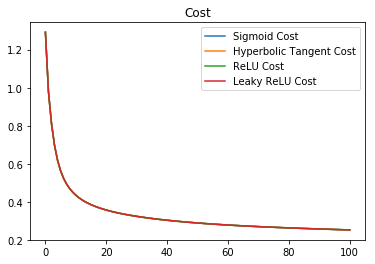

In [206]:
sigmoid_summary = neural_net_sigmoid.summary
tanh_summary = neural_net_tanh.summary
relu_summary = neural_net_relu.summary
lrelu_summary = neural_net_lrelu.summary
plt.plot(range(len(sigmoid_summary[0])), sigmoid_summary[0], label='Sigmoid Cost')
plt.plot(range(len(sigmoid_summary[0])), sigmoid_summary[0], label='Hyperbolic Tangent Cost')
plt.plot(range(len(sigmoid_summary[0])), sigmoid_summary[0], label='ReLU Cost')
plt.plot(range(len(sigmoid_summary[0])), sigmoid_summary[0], label='Leaky ReLU Cost')
plt.legend()
plt.title('Cost')
plt.show()

In [157]:
from keras.models import Sequential
from keras.layers import Dense
X_train, X_test, X_CV = X_train.T, X_test.T, X_CV.T
classifier = Sequential()
classifier.add(Dense(input_dim=4, units = 64, kernel_initializer="uniform", activation="relu"))
classifier.add(Dense(units = 32, kernel_initializer = "uniform", activation="relu"))
# classifier.add(Dense(units = 16, kernel_initializer = "uniform", activation="tanh"))
classifier.add(Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid"))
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
classifier.fit(X_train, y_train, batch_size = 1, epochs = 50)
y_pred = classifier.predict(X_test)
y_pred = 1*(y_pred > 0.5)
test_acc = sum(sum(y_pred.T == y_test)) / y_test.size
print(f"Test set Accuracy : {test_acc*100}%")
X_train, X_test, X_CV = X_train.T, X_test.T, X_CV.T

Epoch 1/50
280/280 [==============================] - 4s 14ms/step - loss: 0.5039 - acc: 0.7750
Epoch 2/50
280/280 [==============================] - 2s 6ms/step - loss: 0.3158 - acc: 0.8893
Epoch 3/50
280/280 [==============================] - 2s 6ms/step - loss: 0.2812 - acc: 0.8893
Epoch 4/50
280/280 [==============================] - 2s 6ms/step - loss: 0.2609 - acc: 0.9036
Epoch 5/50
280/280 [==============================] - 2s 6ms/step - loss: 0.2489 - acc: 0.8929
Epoch 6/50
280/280 [==============================] - 2s 6ms/step - loss: 0.2339 - acc: 0.8964A: 1s
Epoch 7/50
280/280 [==============================] - 2s 7ms/step - loss: 0.2335 - acc: 0.9071
Epoch 8/50
280/280 [==============================] - 1s 5ms/step - loss: 0.2255 - acc: 0.9071
Epoch 9/50
280/280 [==============================] - 1s 5ms/step - loss: 0.2253 - acc: 0.9071
Epoch 10/50
280/280 [==============================] - 1s 4ms/step - loss: 0.2213 - acc: 0.9107
Epoch 11/50
280/280 [======================